### Zadanie 3
Zadanie wykorzystuje pierwsze i drugie prawo Kirchoffa do wyznaczenia wartości natężeń prądów przepływających przez węzły. 
Pomocna jest biblioteka networkx implementująca algorytmy grafowe, posłużyła do znajdowania cykli w grafie oraz do rysowania grafu ważonego.

In [2]:
import csv
import sys
import math
import random
import networkx as nx


class CircuitGenerator:
    def __init__(self, s, t, emf, nodes=10, type_='connected'):
        self.s = s
        self.t = t
        self.emf = emf
        self.nodes = int(nodes)
        self.type_ = type_
        self.edges = self.generate_circuit_edges_list()

    # emf.csv describes electromotive force - its value and two nodes
    def generate_emf(self):
        with open('data/emf.csv', 'w', newline='') as csvfile:
            writer = csv.writer(csvfile,  delimiter=',', quotechar='\'', quoting=csv.QUOTE_MINIMAL)
            writer.writerow(('s', 't', 'E'))
            # sample values
            writer.writerow((self.s, self.t, self.emf))

    # circuit.csv describes edges of the graph - resistance measured between two nodes
    def generate_circuit(self):
        with open('data/circuit.csv', 'w', newline='') as csvfile:
            writer = csv.writer(csvfile,  delimiter=',', quotechar='\'', quoting=csv.QUOTE_MINIMAL)
            writer.writerow(('node 1', 'node 2', 'resistance'))
            # sample values
            for row in self.edges:
                writer.writerow(row)

    def generate_circuit_edges_list(self):
        if self.type_ == 'connected':
            return self.generate_connected_edges_list()
        elif self.type_ == 'cubic':
            return self.generate_cubic_edges_list()
        elif self.type_ == 'bridge':
            return self.generate_bridge_edges_list()
        elif self.type_ == '2d':
            return self.generate_grid_2d_edges_list()

    def generate_grid_2d_edges_list(self):
        edges = []
        n = math.trunc(math.sqrt(self.nodes))
        g = nx.grid_2d_graph(n, n)
        for ((x, y), (z, w), d) in g.edges(data=True):
            edges.append((x*10 + y, z*10 + w, random.randint(1, 10)))
        return edges

    def generate_connected_edges_list(self):
        edges = []
        g = nx.erdos_renyi_graph(self.nodes, 0.5)
        for (u, v, d) in g.edges(data=True):
            edges.append((u, v, random.randint(1, 10)))
        return edges

    def generate_cubic_edges_list(self):
        edges = []
        g = nx.cubical_graph()
        for (u, v, d) in g.edges(data=True):
            edges.append((u, v, random.randint(1, 10)))
        return edges

    def generate_bridge_edges_list(self):
        return []

In [5]:
import csv
from collections import OrderedDict
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


class CircuitAnalyzer:
    def __init__(self):
        self.graph = self.get_graph()
        self.s, self.t, self.emf = self.get_emf_tuple()
        self.graph.add_edge(self.s, self.t, weight=self.emf)
        self.nodes_dict = self.get_nodes_dict()
        self.edges_dict = self.get_edges_dict()
        edges_list = list(self.edges_dict.keys())
        edges_list.sort()
        self.edges_list = edges_list
        self.edges_weights = [self.edges_dict[k] for k in self.edges_list]

    @staticmethod
    def get_emf_tuple():
        with open('data/emf.csv', newline='') as emf_csv:
            reader = csv.DictReader(emf_csv)
            for row in reader:
                return int(row['s']), int(row['t']), float(row['E'])

    @staticmethod
    def get_graph():
        graph = nx.Graph()
        with open('data/circuit.csv', newline='') as circuit_csv:
            reader = csv.DictReader(circuit_csv)
            for row in reader:
                graph.add_edge(int(row['node 1']), int(row['node 2']), weight=float(row['resistance']))
        return graph

    def get_nodes_dict(self):
        n = dict()
        for (u, v, d) in self.graph.edges(data=True):
            n[u] = []
            n[v] = []
        for (u, v, d) in self.graph.edges(data=True):
            n[u].append(v)
            n[v].append(u)
        nodes = list(n.keys())
        nodes.sort()
        ordered_dict = OrderedDict()
        for node in nodes:
            ordered_dict[node] = n[node]

        return ordered_dict

    def get_edges_dict(self):
        w = dict()
        for (u, v, d) in self.graph.edges(data=True):
            w[(u, v)] = d['weight']
        return w

    def get_cycles(self):
        return list(nx.cycle_basis(self.graph))

    def draw_graph(self):
        # positions for all nodes
        pos = nx.fruchterman_reingold_layout(self.graph)

        plt.figure(figsize=(8, 8), facecolor='black')
        # draw nodes
        nx.draw_networkx_nodes(self.graph, pos, node_size=120, node_color='#A0CBE2')
        # draw edges
        nx.draw_networkx_edges(self.graph, pos, edgelist=self.edges_list,
                               edge_color=self.edges_weights,
                               width=4, edge_cmap=plt.cm.Blues, alpha=0.9)
        # draw labels
        nx.draw_networkx_labels(self.graph, pos, font_size=10, font_family='sans-serif')

        plt.axis('off')
        plt.show()

    def find_edge_index(self, node1, node2):
        for i in range(0, len(self.edges_dict)):
            (u, v) = self.edges_list[i]
            if (u == node1 and v == node2) or (u == node2 and v == node1):
                return i
        return -1

    def get_edge_weight(self, node1, node2):
        return self.edges_weights[self.find_edge_index(node1, node2)]

    def first_law_matrices(self):
        rows = []
        for node in iter(self.nodes_dict.keys()):
            row = [0] * len(self.edges_dict)
            neighbours = self.nodes_dict[node]
            for neighbour in neighbours:
                edge_index = self.find_edge_index(node, neighbour)
                if node > neighbour:
                    row[edge_index] = 1
                elif node < neighbour:
                    row[edge_index] = -1
                else:
                    print("its not edge!")
            rows.append(row)
        A = np.array(rows)
        b = np.zeros(len(rows))
        return A, b

    def second_law_matrices(self):
        rows = []
        rows_b = []
        for cycle in self.get_cycles():
            row = [0] * len(self.edges_dict)
            row_b = 0
            for i in range(0, len(cycle)):
                if i == len(cycle) - 1:
                    node1 = cycle[i]
                    node2 = cycle[0]
                else:
                    node1 = cycle[i]
                    node2 = cycle[i+1]
                edge_index = self.find_edge_index(node1, node2)
                edge_weight = self.get_edge_weight(node1, node2)
                if (node1 == self.s and node2 == self.t) or (node1 == self.t and node2 == self.s):
                    if node1 > node2:
                        row_b = -edge_weight
                    elif node1 < node2:
                        row_b = edge_weight
                elif node1 > node2:
                    row[edge_index] = -edge_weight
                elif node1 < node2:
                    row[edge_index] = edge_weight
                else:
                    print("its not edge!")
            rows.append(row)
            rows_b.append(row_b)

        if abs(abs(rows_b[0]) - abs(self.emf)) < 0.00001:
            rows.pop(1)
            rows_b.pop(1)
        else:
            rows.pop(0)
            rows_b.pop(0)
        A = np.array(rows)
        b = np.array(rows_b)
        return A, b

    def concat_laws_matrices(self):
        first_A, first_b = self.first_law_matrices()
        second_A, second_b = self.second_law_matrices()
        A = np.concatenate((first_A, second_A))
        b = np.concatenate((first_b, second_b))
        return A, b

    def solve(self):
        A, b = self.concat_laws_matrices()
        A_transposed = A.transpose()
        A = np.dot(A_transposed, A)
        Y = np.dot(A_transposed, b)
        x = np.linalg.solve(A, b)
        self.edges_weights = x
        return x

### Losowe grafy spójne

In [4]:
generator = CircuitGenerator(1, 2, 11.2, 15, 'connected')
generator.generate_emf()
generator.generate_circuit()

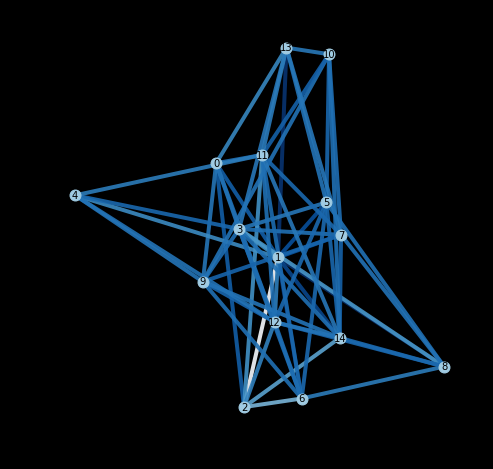

In [6]:
analyzer = CircuitAnalyzer()
analyzer.solve()
analyzer.draw_graph()

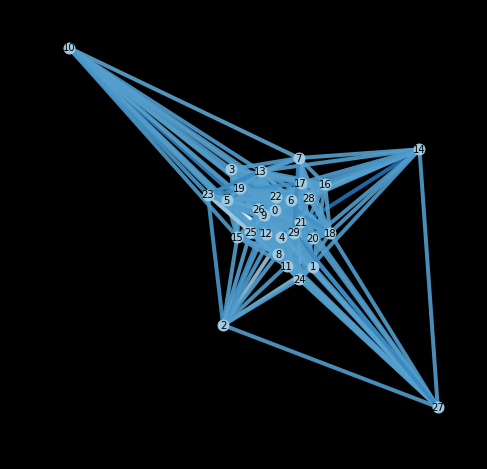

In [11]:
generator = CircuitGenerator(1, 2, 10, 30, 'connected')
generator.generate_emf()
generator.generate_circuit()
analyzer = CircuitAnalyzer()
analyzer.solve()
analyzer.draw_graph()

### Graf kubiczny

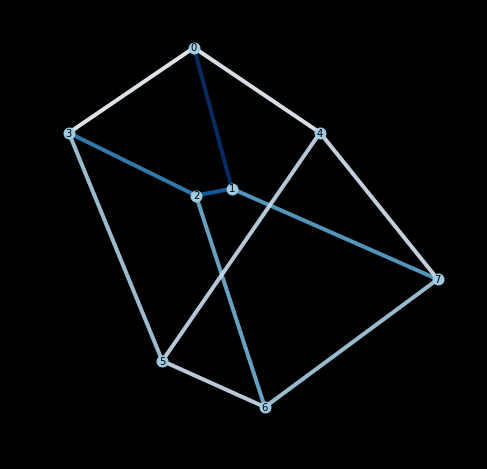

In [12]:
generator = CircuitGenerator(1, 2, 120, 10, 'cubic')
generator.generate_emf()
generator.generate_circuit()
analyzer = CircuitAnalyzer()
analyzer.solve()
analyzer.draw_graph()

### Grafy w postaci siatki 2D

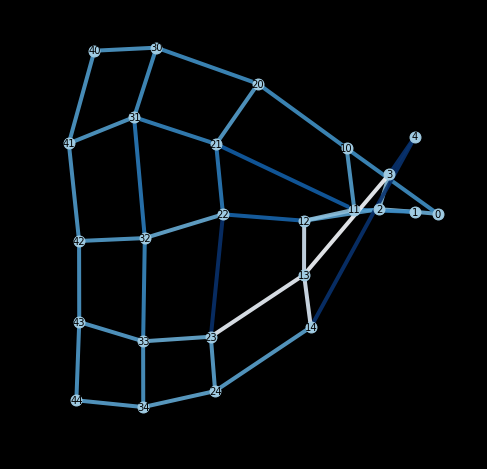

In [13]:
generator = CircuitGenerator(1, 2, 10, 30, '2d')
generator.generate_emf()
generator.generate_circuit()
analyzer = CircuitAnalyzer()
analyzer.solve()
analyzer.draw_graph()

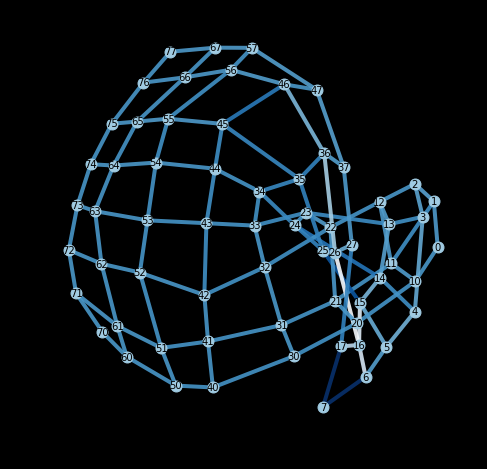

In [15]:
generator = CircuitGenerator(1, 2, 10, 80, '2d')
generator.generate_emf()
generator.generate_circuit()
analyzer = CircuitAnalyzer()
analyzer.solve()
analyzer.draw_graph()

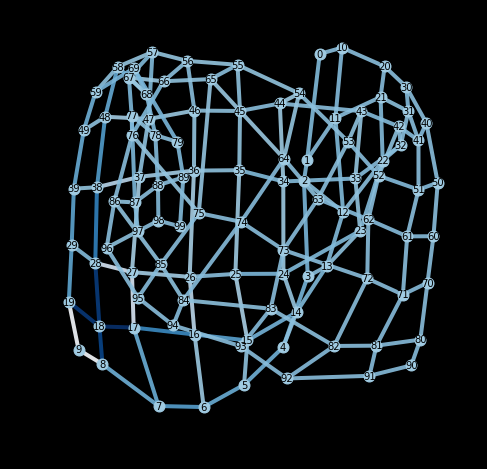

In [16]:
generator = CircuitGenerator(1, 2, 100, 100, '2d')
generator.generate_emf()
generator.generate_circuit()
analyzer = CircuitAnalyzer()
analyzer.solve()
analyzer.draw_graph()